# Importing libraries

In [1]:
!pip install optuna opendatasets --upgrade --quiet

In [2]:
import opendatasets as od 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import model_selection, metrics
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn import ensemble
import xgboost
import warnings

warnings.filterwarnings('ignore')


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
fp = (
    'https://www.kaggle.com/datasets/iabhishekofficial/'
    'mobile-price-classification'
)

od.download(fp)

Skipping, found downloaded files in "./mobile-price-classification" (use force=True to force download)


In [5]:
df_train = pd.read_csv('./mobile-price-classification/train.csv')
df_test = pd.read_csv('./mobile-price-classification/test.csv')

In [6]:
df_train.shape

(2000, 21)

In [7]:
df_test.shape

(1000, 21)

In [8]:
df_train.sample(n=8)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1949,757,1,0.9,1,4,0,64,0.5,157,7,5,114,819,3433,6,5,10,1,1,0,2
1866,907,1,2.6,1,7,0,44,0.2,160,3,12,144,896,3911,13,6,8,0,0,0,3
1994,858,0,2.2,0,1,0,50,0.1,84,1,2,528,1416,3978,17,16,3,1,1,0,3
1487,761,1,0.5,0,9,0,3,0.8,196,7,15,1325,1945,2248,19,3,15,1,1,1,2
8,1445,1,0.5,0,0,0,53,0.7,174,7,14,386,836,1099,17,1,20,1,0,0,0
1963,1906,1,1.9,1,3,0,55,0.2,113,3,4,3,629,1871,13,5,4,1,0,1,1
1989,586,0,2.8,0,2,0,15,0.2,83,3,11,241,854,2592,12,8,3,0,0,0,1
301,977,1,1.1,1,2,0,57,0.6,181,6,7,63,566,1206,7,1,8,0,1,1,0


#### **Missing values**

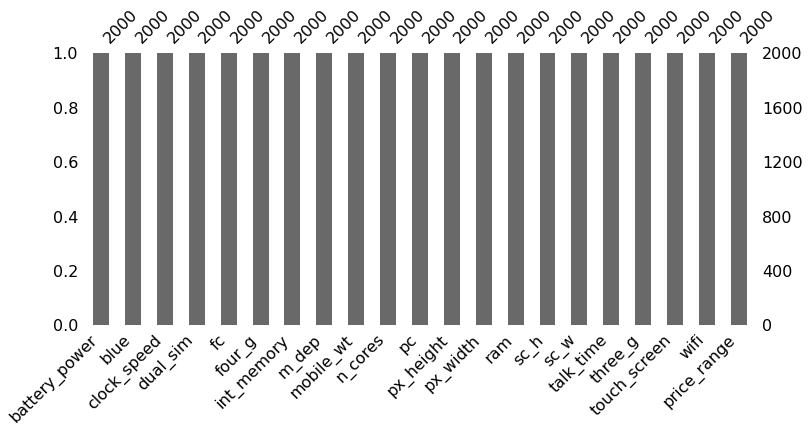

In [9]:
msno.bar(df_train, figsize=(12, 5))

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [12]:
df_train['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

#### separte data

In [13]:
data, target = df_train.drop(columns=['price_range']), df_train['price_range']

#### **Splitting data**

In [14]:
X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
    data,
    target,
    test_size=.2,
    random_state=42,

)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((1600, 20), (1600,), (400, 20), (400,))

In [15]:
numerical = X_train.columns
numerical

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [16]:
processor = ColumnTransformer([
    ('sca', StandardScaler(), numerical)
])

models = [
    DummyClassifier,
    LogisticRegression,
    tree.DecisionTreeClassifier,
    ensemble.HistGradientBoostingClassifier,
    ensemble.RandomForestClassifier,
    xgboost.XGBClassifier,
]

model_names = [
    'DummyClassifier',
    'LogisticRegression',
    'DecisionTreeClassifier',
    'HistGradientBoostingClassifier',
    'RandomForestClassifier',
    'XGBClassifier',
]
results = {}

for model in models:
  if model == LogisticRegression:
    cls = Pipeline([
        ('processor',processor), 
        ('classifier', model())
    ])
  else:
    cls = model()
  
  kfold = model_selection.KFold(
      n_splits=10,
      shuffle=True,
      random_state=42,
  )
  cv_results = model_selection.cross_validate(
      cls,
      data,
      target,
      cv=kfold,
      scoring='accuracy',
      n_jobs=-1
  )

  for name in model_names:
    results[name] = cv_results
  
  if model == LogisticRegression:
    print(f"LogisticRegression AUC: {cv_results['test_score'].mean(): .3f} "
          f"+/- STD: {cv_results['test_score'].std(): .3f}"
    )

  else:
    print(f"{model.__name__:22} AUC: {cv_results['test_score'].mean(): .3f} "
         f"+/- STD: {cv_results['test_score'].std(): .3f}"
    )


DummyClassifier        AUC:  0.225 +/- STD:  0.012
LogisticRegression AUC:  0.963 +/- STD:  0.019
DecisionTreeClassifier AUC:  0.831 +/- STD:  0.017
HistGradientBoostingClassifier AUC:  0.912 +/- STD:  0.017
RandomForestClassifier AUC:  0.882 +/- STD:  0.016
XGBClassifier          AUC:  0.907 +/- STD:  0.017


In [17]:
results

{'DummyClassifier': {'fit_time': array([1.7474196 , 1.9641397 , 1.47835469, 1.89479136, 1.66419244,
         1.83753681, 2.13570738, 1.46845508, 2.30563974, 2.02361155]),
  'score_time': array([0.01319766, 0.01697254, 0.01297545, 0.00577736, 0.0208776 ,
         0.0147686 , 0.00578737, 0.01278472, 0.01594996, 0.01441741]),
  'test_score': array([0.9  , 0.885, 0.89 , 0.92 , 0.93 , 0.89 , 0.93 , 0.93 , 0.905,
         0.895])},
 'LogisticRegression': {'fit_time': array([1.7474196 , 1.9641397 , 1.47835469, 1.89479136, 1.66419244,
         1.83753681, 2.13570738, 1.46845508, 2.30563974, 2.02361155]),
  'score_time': array([0.01319766, 0.01697254, 0.01297545, 0.00577736, 0.0208776 ,
         0.0147686 , 0.00578737, 0.01278472, 0.01594996, 0.01441741]),
  'test_score': array([0.9  , 0.885, 0.89 , 0.92 , 0.93 , 0.89 , 0.93 , 0.93 , 0.905,
         0.895])},
 'DecisionTreeClassifier': {'fit_time': array([1.7474196 , 1.9641397 , 1.47835469, 1.89479136, 1.66419244,
         1.83753681, 2.1357073

# Hyper parameters tuning for best models

#### ** Randomized search cv**

In [18]:
from scipy.stats import loguniform


cls = Pipeline([
        ('processor',processor), 
        ('classifier', LogisticRegression(max_iter=1000))
    ])

best_models = [ensemble.HistGradientBoostingClassifier, cls]

param_distributions = [
    {
        'loss': ['auto', 'categorical_crossentropy'],
        'learning_rate': loguniform(0.001, 10),
        'max_leaf_nodes': [2, 3, 5, 10, 15],
        'max_depth': [1, 3, 5, 15],
        'min_samples_leaf': [1, 2, 3, 5, 10, 20]
    },
    {
        'classifier__penalty': ['none', 'l2'],
        'classifier__C': [1.0, 2., 5, 10, 15],
    },
]

kfold = model_selection.KFold(
      n_splits=10,
      shuffle=True,
      random_state=42,
  )

model_random_search = {}
names = ['HistGradientBoostingClassifier', 'LogisticRegression']

for model, param, name in zip(best_models, param_distributions, names):
  if name == 'HistGradientBoostingClassifier':
    model = model()

  model_random_search[name] = model_selection.RandomizedSearchCV(
      model,
      param_distributions=param,
      n_iter = 20,
      cv = kfold,
      verbose=1,
      n_jobs=-1,

  )

In [19]:
%%time

results = []

for name, estim in model_random_search.items():
  cv_results = model_selection.cross_validate(
      estim,
      data,
      target,
      cv=kfold,
      n_jobs=-1,
      return_estimator=True,
      verbose=10,

  )
  results.append({name:cv_results})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.7min


CPU times: user 4.56 s, sys: 614 ms, total: 5.17 s
Wall time: 13min 19s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.8min finished


In [20]:
for i, name in zip(range(len(results)), names):
  for fold_idx, estimator in enumerate(results[i][name]['estimator']):
    # print(results[i][name]['estimator'])
    print(name)
    print(f"Best parameter found on fold #{fold_idx + 1}")
    print(f"{estimator.best_params_}")
    print()
    print('**-**' * 20)
    print()

HistGradientBoostingClassifier
Best parameter found on fold #1
{'learning_rate': 0.6560699916942081, 'loss': 'auto', 'max_depth': 15, 'max_leaf_nodes': 2, 'min_samples_leaf': 2}

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**

HistGradientBoostingClassifier
Best parameter found on fold #2
{'learning_rate': 0.5399820598623976, 'loss': 'auto', 'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 20}

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**

HistGradientBoostingClassifier
Best parameter found on fold #3
{'learning_rate': 0.5819528245950498, 'loss': 'auto', 'max_depth': 3, 'max_leaf_nodes': 2, 'min_samples_leaf': 2}

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**

HistGradientBoostingClassifier
Best parameter found on fold #4
{'learning_rate': 0.38503320699435895, 'loss': 'auto', 'max_depth': 5, 'max_leaf_nodes': 3, 'mi

We can constat that we obtain models with unstable hyperparameters.

In [21]:
param_distributions_histgrad = {
        'loss': ['auto', 'categorical_crossentropy'],
        'learning_rate': loguniform(0.001, 10),
        'max_leaf_nodes': [2, 3, 5, 10, 15],
        'max_depth': [1, 3, 5, 15],
        'min_samples_leaf': [1, 2, 3, 5, 10, 20]
    }

classifier_histgrad = ensemble.HistGradientBoostingClassifier()

model_histgrad = model_selection.RandomizedSearchCV(
    classifier_histgrad,
    param_distributions=param_distributions_histgrad,
    n_iter=20,
    scoring='accuracy',
    verbose=10,
    cv=kfold,
    n_jobs=-1,
    error_score='raise'

).fit(X_train, y_train)

print(f"best score: {model_histgrad.best_score_}")
print('best parameters set: ')
best_parameters = model_histgrad.best_estimator_.get_params()

for param_name in sorted(param_distributions_histgrad.keys()):
  print(f"\t {param_name}: {best_parameters[param_name]}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
best score: 0.9168750000000001
best parameters set: 
	 learning_rate: 0.4384748164117539
	 loss: auto
	 max_depth: 1
	 max_leaf_nodes: 15
	 min_samples_leaf: 1


In [22]:
param_distributions_log_reg = {
    'classifier__penalty': ['l2', 'none'],
    'classifier__C': [1.0, 2., 5, 10, 15],
}

cls = Pipeline([
        ('processor',processor), 
        ('classifier', LogisticRegression(max_iter=250))
    ])

model_logreg = model_selection.RandomizedSearchCV(
    cls,
    param_distributions=param_distributions_log_reg,
    n_iter=20,
    scoring='accuracy',
    verbose=10,
    cv=kfold,
    n_jobs=-1,
    error_score='raise'

).fit(X_train, y_train)

print(f"best score: {model_logreg.best_score_}")
print('best parameters set: ')
best_parameters = model_logreg.best_estimator_.get_params()

for param_name in sorted(param_distributions_log_reg.keys()):
  print(f"\t {param_name}: {best_parameters[param_name]}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best score: 0.9662499999999999
best parameters set: 
	 classifier__C: 1.0
	 classifier__penalty: none


# Hyperparameters Using Bayesian optimization with gaussian process

In [23]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [24]:
from functools import partial
from skopt import gp_minimize, space


def optimize(params, param_names, x, y):
  """ 
  The main optimization function.
  This function takes all the arguments from the search space
  and training features and targets. It then initializes
  the models by setting the chosen parameters and runs
  cross-validation and returns a negative accuracy score
  :param params: list of params from gp_minimize
  :param param_names: list of param names. order is important!
  :param x: training data
  :param y: labels/targets
  :return: negative accuracy after 10 folds
  """

  # convert params to dictionary
  params = dict(zip(param_names, params))

  # initialize model with current parameters
  model = ensemble.HistGradientBoostingClassifier(**params)

  # initialize k-fold
  kf = model_selection.KFold(n_splits=10)

  # initialize accuracy list
  accuracies = []

  # loop over all folds
  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    # fit model for current fold
    model.fit(xtrain, ytrain)

    #create predictions
    preds = model.predict(xdev)

    # calculate and append accuracy
    fold_accuracy = metrics.accuracy_score(ydev, preds)
    accuracies.append(fold_accuracy)

    # return negative accuracy
    return -1 * np.mean(accuracies)

In [25]:
# param_distributions_histgrad = {
#         'loss': ['auto', 'categorical_crossentropy'],
#         'learning_rate': loguniform(0.001, 10),
#         'max_leaf_nodes': [2, 3, 5, 10, 15],
#         'max_depth': [1, 3, 5, 15],
#         'min_samples_leaf': [1, 2, 3, 5, 10, 20]
#     }
# define a parameter space for HistGradientboostingClassifier

param_space = [
    # loss is a category. here we define list of categories
    space.Categorical(['auto', 'categorical_crossentropy'], name='loss'),
    space.Real(0.001, 10, prior='uniform', name='learning_rate'),
    space.Integer(2, 15, name='max_leaf_nodes'),
    space.Integer(1, 15, name='max_depth'),
    space.Integer(1, 20, name='min_samples_leaf'),
]

# make a list of param names
# this has to be same order as the search space
# inside the main function
param_names = [
    'loss',
    'learning_rate',
    'max_leaf_nodes',
    'max_depth',
    'min_samples_leaf'
]

# by using functools partial, i am creating a
# new function which has same parameters as the
# optimize function except for the fact that
# only one param, i.e. the "params" parameter is
# required. this is how gp_minimize expects the
# optimization function to be. you can get rid of this
# by reading data inside the optimize function or by
# defining the optimize function here.
optimization_function = partial(
    optimize,
    param_names=param_names,
    x=X_train.values,
    y=y_train.values,
)

# now we call gp_minimize from scikit-optimize
# gp_minimize uses bayesian optimization for
# minimization of the optimization function.
# we need a space of parameters, the function itself,
# the number of calls/iterations we want to have
result_ = gp_minimize(
    optimization_function,
    dimensions=param_space,
    n_calls=15,
    n_random_starts=10,
    verbose=10
)

# create best params dict and print it
best_params = dict(zip(param_names, result_.x))
print(best_params)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1421
Function value obtained: -0.0688
Current minimum: -0.0688
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0394
Function value obtained: -0.8938
Current minimum: -0.8938
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1417
Function value obtained: -0.0688
Current minimum: -0.8938
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1464
Function value obtained: -0.0688
Current minimum: -0.8938
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1854
Function value obtained: -0.4125
Current minimum: -0.8938
Iteration No: 6 started. 

It seems like we have decreasing accuracy from 0.92 with randomized search cv to 0.9 with bayesian optimisation.

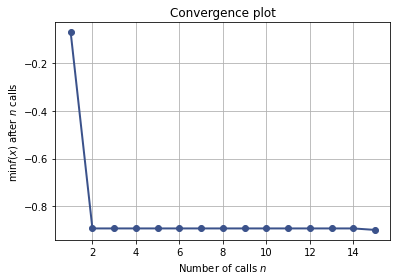

In [26]:
from skopt.plots import plot_convergence

plot_convergence(result_)

In [27]:
from functools import partial
from skopt import gp_minimize, space


def optimize(params, param_names, x, y):
  """ 
  The main optimization function.
  This function takes all the arguments from the search space
  and training features and targets. It then initializes
  the models by setting the chosen parameters and runs
  cross-validation and returns a negative accuracy score
  :param params: list of params from gp_minimize
  :param param_names: list of param names. order is important!
  :param x: training data
  :param y: labels/targets
  :return: negative accuracy after 10 folds
  """

  # convert params to dictionary
  params = dict(zip(param_names, params))

  # initialize model with current parameters
  model = LogisticRegression(**params)

  # initialize k-fold
  kf = model_selection.KFold(n_splits=10)

  # initialize accuracy list
  accuracies = []

  # loop over all folds
  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    # fit model for current fold
    model.fit(xtrain, ytrain)

    #create predictions
    preds = model.predict(xdev)

    # calculate and append accuracy
    fold_accuracy = metrics.accuracy_score(ydev, preds)
    accuracies.append(fold_accuracy)

    # return negative accuracy
    return -1 * np.mean(accuracies)

In [28]:
X_train_sca = X_train.copy()
X_dev_sca = X_dev.copy()

sca = StandardScaler()
X_train_sca = sca.fit_transform(X_train_sca)
X_train_sca = pd.DataFrame(X_train_sca, columns=X_train.columns)
X_dev_sca = sca.transform(X_dev_sca)
X_dev_sca = pd.DataFrame(X_dev_sca, columns=X_dev.columns)

X_dev_sca.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0.919657,-0.981423,1.202995,-1.030464,-0.301987,0.955968,-0.399682,0.339750,1.680472,-1.110623,-0.811268,-0.972891,0.831970,-1.323738,-1.003792,0.067867,0.007832,0.557137,0.990050,-0.997503
1,-0.133477,-0.981423,-1.236230,-1.030464,0.620111,0.955968,-1.334288,-0.008935,-0.074553,1.510316,1.018112,-0.829167,-0.609863,0.413624,1.612728,2.603886,1.460787,0.557137,-1.010051,-0.997503


In [29]:

# define a parameter space for LogisticRegressionClassifier

param_space = [
    space.Integer(1, 15, name='C'),
    space.Categorical(['l2', 'none'], name='penalty'),
]

# make a list of param names
# this has to be same order as the search space
# inside the main function
param_names = [
    'C',
    'penalty',
]

# by using functools partial, i am creating a
# new function which has same parameters as the
# optimize function except for the fact that
# only one param, i.e. the "params" parameter is
# required. this is how gp_minimize expects the
# optimization function to be. you can get rid of this
# by reading data inside the optimize function or by
# defining the optimize function here.
optimization_function = partial(
    optimize,
    param_names=param_names,
    x=X_train_sca.values,
    y=y_train.values,
)

# now we call gp_minimize from scikit-optimize
# gp_minimize uses bayesian optimization for
# minimization of the optimization function.
# we need a space of parameters, the function itself,
# the number of calls/iterations we want to have
result = gp_minimize(
    optimization_function,
    dimensions=param_space,
    n_calls=15,
    n_random_starts=10,
    verbose=10
)

# create best params dict and print it
best_params = dict(zip(param_names, result.x))
print(best_params)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1517
Function value obtained: -0.9500
Current minimum: -0.9500
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2612
Function value obtained: -0.9500
Current minimum: -0.9500
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1267
Function value obtained: -0.9437
Current minimum: -0.9500
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1723
Function value obtained: -0.9500
Current minimum: -0.9500
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1271
Function value obtained: -0.9437
Current minimum: -0.9500
Iteration No: 6 started. 

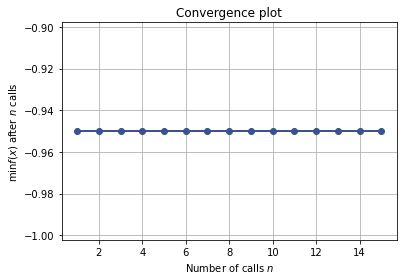

In [30]:
from skopt.plots import plot_convergence
plot_convergence(result)

# Hyperparameters Using Optuna

In [31]:
import optuna


def optimize(trial, x, y):
  C = trial.suggest_int("C", 1, 15)
  penalty = trial.suggest_categorical("penalty", ['l2', 'none'])
  model = LogisticRegression(C=C, penalty=penalty, max_iter=1000)

  kf = model_selection.KFold(n_splits=10)
  accuracies = []


  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    
    model.fit(xtrain, ytrain)
    preds = model.predict(xdev)

    fold_accuracy = metrics.accuracy_score(ydev, preds)
    accuracies.append(fold_accuracy)

    return -1 * np.mean(accuracies)

optimization_function = partial(optimize,x=X_train_sca.values, y=y_train.values)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=15)

[I 2022-10-10 15:48:27,484] A new study created in memory with name: no-name-00ab3b6a-593f-439d-bae3-f75aacd2faf6
[I 2022-10-10 15:48:28,420] Trial 0 finished with value: -0.9625 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 0 with value: -0.9625.
[I 2022-10-10 15:48:28,494] Trial 1 finished with value: -0.94375 and parameters: {'C': 12, 'penalty': 'l2'}. Best is trial 0 with value: -0.9625.
[I 2022-10-10 15:48:29,439] Trial 2 finished with value: -0.9625 and parameters: {'C': 7, 'penalty': 'none'}. Best is trial 0 with value: -0.9625.
[I 2022-10-10 15:48:31,007] Trial 3 finished with value: -0.9625 and parameters: {'C': 2, 'penalty': 'none'}. Best is trial 0 with value: -0.9625.
[I 2022-10-10 15:48:31,146] Trial 4 finished with value: -0.95 and parameters: {'C': 15, 'penalty': 'l2'}. Best is trial 0 with value: -0.9625.
[I 2022-10-10 15:48:32,953] Trial 5 finished with value: -0.9625 and parameters: {'C': 3, 'penalty': 'none'}. Best is trial 0 with value: -0.9625.
[I 2022